In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pandas as pd
import numpy as np

In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [34]:
pd.set_option('display.max_columns', None)

#### Load the experiment df `ca1_train` and `ca1_test`

In [35]:
ca1_train = pd.read_parquet('../data/interim/predictive_ca1_train.to_parquet')
ca1_test = pd.read_parquet('../data/interim/predictive_ca1_test.to_parquet')

In [6]:
import sys
sys.path.insert(0, '../src')

#### Import the `preprocess` function to preprocess the data
- Extract date-related features from the `date` column
- Add `seasonality-feature`
- `Label Encoding` the categorical features
- Drop `id`, `date`, `wm_yr_wk`, `d`,  `event_name`, `event_type` features

In [7]:
from features.data_prep import preprocess

In [8]:
df_train, item_id_encoder, dept_id_encoder, store_id_encoder, state_id_encoder, cat_id_encoder = preprocess(ca1_train.copy())

In [9]:
df_test = preprocess(ca1_test.copy())[0]

In [10]:
df_test

,item_id,dept_id,cat_id,store_id,state_id,sales,sell_price,total_sales,year,month,day_of_week,ema_sales_7,rolling_std_7,ema_sales_14,rolling_std_14,ema_sales_21,rolling_std_21,ema_sales_28,rolling_std_28
47107050,1437,3,1,0,0,0,8.26,0.00,2015,4,6,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
47107051,1438,3,1,0,0,0,3.97,0.00,2015,4,6,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
47107052,1439,3,1,0,0,0,2.97,0.00,2015,4,6,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN
47107053,1440,3,1,0,0,4,4.64,18.56,2015,4,6,6.787657,NaN,5.678028,NaN,5.322853,NaN,5.148542,NaN
47107054,1441,3,1,0,0,3,2.88,8.64,2015,4,6,7.394827,NaN,6.450802,NaN,6.118357,NaN,5.950017,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59275604,1432,2,0,0,0,2,2.98,5.96,2016,5,6,10.691358,10.094889,9.056182,9.528396,8.352400,8.365220,8.160888,7.714424
59275605,1433,2,0,0,0,0,2.48,0.00,2016,5,6,8.018519,10.840774,7.848691,9.824013,7.593091,8.438571,7.598068,7.714424
59275606,1434,2,0,0,0,1,3.98,3.98,2016,5,6,7.008889,10.379017,7.332865,9.405035,7.264628,8.434333,7.348546,7.711141
59275607,1435,2,0,0,0,1,1.28,1.28,2016,5,6,5.576667,10.846627,6.525817,9.474805,6.720571,8.457642,6.930026,7.679661


#### Import `extract_features_target` function

In [11]:
from features.data_prep import extract_features_target

In [12]:
X_train, X_test, y_train, y_test = extract_features_target(df_train, df_test, 'total_sales')

#### Imoprt the `XGBRegressor`, and use `RMSE` as a performance metrics.

In [13]:
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error

#### Run the experiment of the `learning_rate` and `max_depth` features:
- `learning_rate`: from range 0.16 - 0.32 with a step of 0.05.
- `max_depth`: from range 3 to 10.

In [17]:
learning_rate = np.arange(0.16, 0.32, 0.05)
max_depth = np.arange(3, 10)

for lr in learning_rate:
    for md in max_depth:
        xgb_ht = XGBRegressor(objective = 'reg:tweedie', learning_rate = lr, max_depth = md, subsample = 0.7, 
                            colsample_bytree = 0.7, n_estimators = 100) 
        
        xgb_ht.fit(X_train,y_train)
        y_pred = xgb_ht.predict(X_test)
        rmse = mean_squared_error(y_test,y_pred, squared=False)

        print(f"Learning Rate: {lr}, Max Depth: {md},\n  RMSE Sales: {rmse}")
        print("\n")

Learning Rate: 0.16, Max Depth: 3,
  RMSE Sales: 1.7271137625004858


Learning Rate: 0.16, Max Depth: 4,
  RMSE Sales: 1.5618586224083286


Learning Rate: 0.16, Max Depth: 5,
  RMSE Sales: 1.2360777739331033


Learning Rate: 0.16, Max Depth: 6,
  RMSE Sales: 1.1350620524475534


Learning Rate: 0.16, Max Depth: 7,
  RMSE Sales: 0.9793070511027503


Learning Rate: 0.16, Max Depth: 8,
  RMSE Sales: 0.9050988953449216


Learning Rate: 0.16, Max Depth: 9,
  RMSE Sales: 0.8357229957931903


Learning Rate: 0.21000000000000002, Max Depth: 3,
  RMSE Sales: 1.4796588467549066


Learning Rate: 0.21000000000000002, Max Depth: 4,
  RMSE Sales: 1.2951901284178793


Learning Rate: 0.21000000000000002, Max Depth: 5,
  RMSE Sales: 1.1011053291981276


Learning Rate: 0.21000000000000002, Max Depth: 6,
  RMSE Sales: 0.9772545930022348


Learning Rate: 0.21000000000000002, Max Depth: 7,
  RMSE Sales: 0.8957232254409089


Learning Rate: 0.21000000000000002, Max Depth: 8,
  RMSE Sales: 0.8587366398539528




#### The best parameters for
- `learning_rate`: 0.16
- `max_depth`: 9

In [18]:
xgb = XGBRegressor(objective='reg:tweedie', learning_rate=0.16, max_depth=9, subsample=0.7, colsample_bytree=0.7, n_estimators=100)
xgb.fit(X_train,y_train, eval_set=[(X_test, y_test)], eval_metric='rmse', verbose=10)

/Users/narongvatchingpayakmon/.pyenv/versions/3.9.13/lib/python3.9/site-packages/xgboost/sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:11.23428
[10]	validation_0-rmse:7.03659
[20]	validation_0-rmse:2.96771
[30]	validation_0-rmse:1.60821
[40]	validation_0-rmse:1.30245
[50]	validation_0-rmse:1.16157
[60]	validation_0-rmse:1.06275
[70]	validation_0-rmse:0.99248
[80]	validation_0-rmse:0.91005
[90]	validation_0-rmse:0.87108
[99]	validation_0-rmse:0.83572


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.16, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, objective='reg:tweedie', ...)

#### Plot the Feature Importance

In [21]:
import matplotlib.pyplot as plt

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

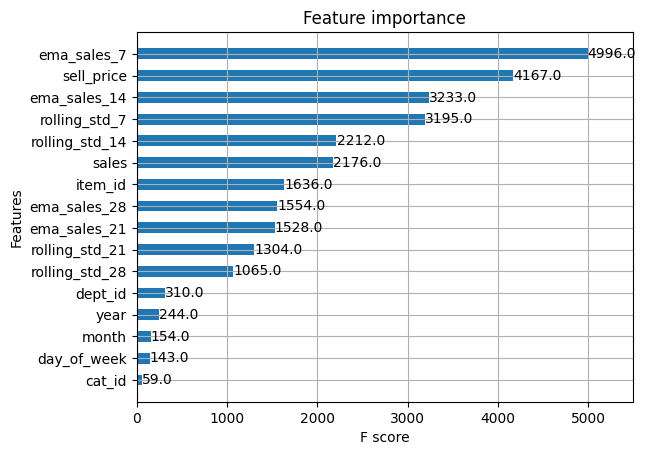

In [22]:
plot_importance(xgb, height=0.5)

#### Trial the observation with missing value in `sales`, `ema`, `rolling_std`, and `lag`

In [26]:
obs = X_test.iloc[[1]]
obs.iloc[:, 11:] = np.nan

In [27]:
obs.loc[:, 'sales'] = 0.879433

In [28]:
obs

,item_id,dept_id,cat_id,store_id,state_id,sales,sell_price,year,month,day_of_week,ema_sales_7,rolling_std_7,ema_sales_14,rolling_std_14,ema_sales_21,rolling_std_21,ema_sales_28,rolling_std_28
47107051,1438,3,1,0,0,0.879433,3.97,2015,4,6,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
y_pred = xgb.predict(obs)
y_pred

array([2.6184367e-12], dtype=float32)

In [30]:
y_pred = xgb.predict(X_test)

predicted_total_sales = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
predicted_total_sales

,y_test,y_pred
47107050,0.00,7.006655e-13
47107051,0.00,9.475575e-13
47107052,0.00,1.320440e-12
47107053,18.56,1.297624e+00
47107054,8.64,4.638551e-01
...,...,...
59275604,5.96,5.985296e+00
59275605,0.00,7.138665e-09
59275606,3.98,3.552915e+00
59275607,1.28,1.124797e+00
